# 学習済みCNNの特定クラスのイメージ画像を生成してみた

今回使用した学習済みCNNはKerasから簡単に使えるVGG16

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# 「PythonとKerasによるディープラーニング」ではinclude_top=Falseとなっているが、
# 最終的にクラス分類を行う全結合層の結果出力から逆算して計算するので、
# include_top=Trueとして全結合層を含める必要がある
vgg16 = VGG16(weights="imagenet", include_top=True)

In [3]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
from keras import backend as K
from tqdm import trange    # ループの進捗を可視化したり、残り時間を表示するライブラリ
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 戻り値：計算された特定クラスのイメージ画像テンソル（有効な画像ではないのでdeprocess_imageする必要がある）
# num_iterは勾配上昇法のステップ数
def generate_image(model, class_id, num_iter):
    
    # 「PythonとKerasによるディープラーニング」ではblock3_conv1を指定しているが、
    # フィルターの可視化ではなく、特定クラスの可視化を行いたいので、
    # 最終層を指定する
    layer_name = "predictions"
    
    layer_output = model.get_layer(layer_name).output
    
    # $$$ここがポイント
    # lossを最終層の指定クラスの出力の平均とする
    loss = K.mean(layer_output[:, class_id])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    # 最初はノイズが含まれたグレースケール画像を使用
    input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128
    
    # 各勾配の更新の大きさ
    step = 1.
    
    # 勾配上昇法をnum_iterステップ実行
    for i in trange(num_iter):
        # 損失値と勾配値を計算
        loss_value, grads_value = iterate([input_img_data])
            
        # 損失が最大になる方向に入力画像を調整
        input_img_data += grads_value * step
        
    return input_img_data

In [6]:
# テンソルを有効な画像に変換するユーティリティ関数
# 「PythonとKerasによるディープラーニング」p177のものと全く同じ

def deprocess_image(x):
    # テンソルを正規化：中心を0、標準偏差を0.1にする
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # [0, 1]でクリッピング
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # RGB配列に変換
    x *= 255
    x = np.clip(x, 0, 255).astype("uint8")
    x = x.reshape((224, 224, 3))
    
    return x

### VGG16の123番目のクラスを7000回イテレーションして可視化する

In [7]:
generated_image = generate_image(vgg16, 123, 7000)

100%|██████████| 7000/7000 [46:50<00:00,  2.59it/s]


In [8]:
generated_image = deprocess_image(generated_image)

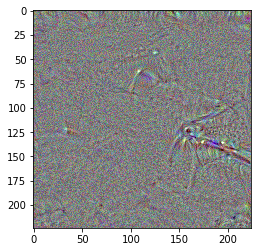

In [9]:
plt.imshow(generated_image)
plt.show()

## 何を可視化したのか日本語名を表示する

In [ ]:
import json

In [ ]:
# ImageNetのラベル一覧を読み込む。
with open('imagenet_class_index.json') as f:
    data = json.load(f)
    class_names = np.array([row['ja'] for row in data])

In [ ]:
class_names[123]